### Ckecking the GPU :

In [71]:
import tensorflow as tf 

In [72]:
tf.test.is_built_with_cuda()

True

In [73]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [74]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import libraries :

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
%matplotlib inline

### Import data :

In [76]:
infile = open('C:/Users/Saberi/Downloads/train.pickle','rb')
train_dict = pickle.load(infile)
infile.close()

infile = open('C:/Users/Saberi/Downloads/test.pickle','rb')
test_dict = pickle.load(infile)
infile.close()

infile = open('C:/Users/Saberi/Downloads/valid.pickle','rb')
valid_dict = pickle.load(infile)
infile.close()

sign=pd.read_csv('C:/Users/Saberi/Downloads/label_names.csv')
sign['SignName'] = (sign['SignName']).astype("string")

In [77]:
sign.head(4)

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)

### Getting to know the data :

In [78]:
train_dict.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

Our images are in the 'features' key.

In [79]:
train_dict['features'].shape

(34799, 32, 32, 3)

In [80]:
pd.DataFrame(train_dict['labels']).info()
#we have no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34799 entries, 0 to 34798
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       34799 non-null  uint8
dtypes: uint8(1)
memory usage: 34.1 KB


### Preparing the data for  our network :

a) preparing the training data

In [112]:
### gray version of the images
train_x_gray=np.array(tf.image.rgb_to_grayscale(train_dict['features'])) 
### rgb version of the images
train_x_rgb=train_dict['features']
### our numeric labels
train_y=train_dict['labels'].reshape(len(train_dict['labels']),1) 

print("shape of the gray training data : ",train_x_gray.shape)
print("shape of the rgb training data : ",train_x_rgb.shape)
print("shape of the training labels : ",train_y.shape)

shape of the gray training data :  (34799, 32, 32, 1)
shape of the rgb training data :  (34799, 32, 32, 3)
shape of the training labels :  (34799, 1)


b) preparing the validation data :

In [113]:
### gray version of the images
valid_x_gray=np.array(tf.image.rgb_to_grayscale(valid_dict['features'])) 
### rgb version of the images
valid_x_rgb=valid_dict['features'] 
### our numeric labels
valid_y=valid_dict['labels'].reshape(len(valid_dict['labels']),1)

print("shape of the gray valid data : ",valid_x_gray.shape)
print("shape of the rgb valid data : ",valid_x_rgb.shape)
print("shape of the valid labels : ",valid_y.shape)

shape of the gray valid data :  (4410, 32, 32, 1)
shape of the rgb valid data :  (4410, 32, 32, 3)
shape of the valid labels :  (4410, 1)


c) preparing the test data :

In [114]:
### gray version of the images
test_x_gray=np.array(tf.image.rgb_to_grayscale(test_dict['features'])) 
### rgb version of the images
test_x_rgb=test_dict['features'] 
### our numeric labels
test_y=test_dict['labels'].reshape(len(test_dict['labels']),1)

print("shape of the gray test data : ",test_x_gray.shape)
print("shape of the rgb test data : ",test_x_rgb.shape)
print("shape of the test labels : ",test_y.shape)

shape of the gray test data :  (12630, 32, 32, 1)
shape of the rgb test data :  (12630, 32, 32, 3)
shape of the test labels :  (12630, 1)


#### coverting the response variable to one-hot encode format :

In [115]:
from tensorflow.keras.utils import to_categorical

train_y=to_categorical(train_y,sign.shape[0])

valid_y=to_categorical(valid_y,sign.shape[0])

test_y=to_categorical(test_y,sign.shape[0])

print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(34799, 43)
(4410, 43)
(12630, 43)


____________________________________________________________________________________

### Applying histogram equalizer on train/test/validation sets :

In [116]:
img=test_x_rgb[0,:,:,:]

In [117]:
def histogram_equalization(df):
    img_out=df.copy()
    for i in range(len(df)):
        img=df[i,:,:,:]
        # split color channels
        b,g,r = cv2.split(img)
        h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
        h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
        h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
        # calculate cdf    
        cdf_m_b = np.cumsum(h_b)  
        cdf_m_g = np.cumsum(h_g)
        cdf_m_r = np.cumsum(h_r)
    

        cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
        cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')
  

        cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
        cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    
        cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
        cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
    
        # merge the images in the three channels
        img_b = cdf_final_b[b]
        img_g = cdf_final_g[g]        
        img_r = cdf_final_r[r]
  
        img_out[i,:,:,:]=cv2.merge((img_b, img_g, img_r))
    
    
    return img_out

equalize train/test/validation rgb images :

In [118]:
eq_train_x_rgb=histogram_equalization(train_x_rgb)
eq_valid_x_rgb=histogram_equalization(valid_x_rgb)
eq_test_x_rgb=histogram_equalization(test_x_rgb)

make equalized gray images from equalized rgb images :

In [119]:
eq_train_x_gray=np.array(tf.image.rgb_to_grayscale(eq_train_x_rgb))
eq_valid_x_gray=np.array(tf.image.rgb_to_grayscale(eq_valid_x_rgb))
eq_test_x_gray=np.array(tf.image.rgb_to_grayscale(eq_test_x_rgb))

## Visualizing some of the data in RGB and gray format without histogram equalization :

##### writing a function to randomly plot 9 images of gray or rgb pictures regarding to a specified label:

In [120]:
import random
def get_rgb_pic(i,df):
    random.seed(4)
    samp=np.array(random.sample(list(df[train_dict['labels']==i]),9))
    fig, axes = plt.subplots(nrows=1, ncols=9,figsize=(15,15))
    for j in range(0,9):
        img = samp[j]
        axes[j].imshow(img)
        axes[j].axis('off')
    a=sign[sign['ClassId']==i]['SignName'].values[0]
    axes[4].set_title(f"some pictures of class {i} which is {a} sign",loc='center')   

    plt.show()

def get_gray_pic(i,df):
    random.seed(4)
    samp=np.array(random.sample(list(df[train_dict['labels']==i]),9))
    fig, axes = plt.subplots(nrows=1, ncols=9,figsize=(15,15))
    for j in range(0,9):
        img = samp[j,:,:,0]
        axes[j].imshow(img)
        axes[j].axis('off')
    a=sign[sign['ClassId']==i]['SignName'].values[0]
    axes[4].set_title(f"some pictures of class {i} which is {a} sign",loc='center')    

    plt.show() 

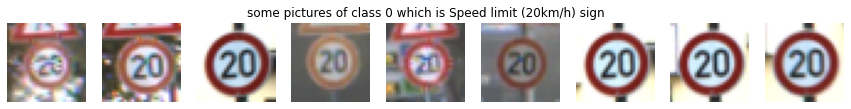

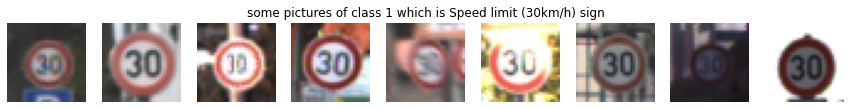

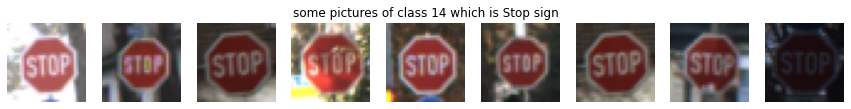

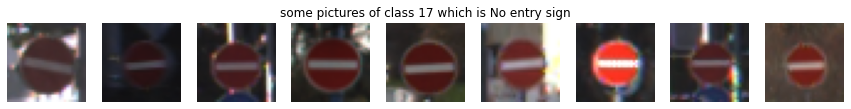

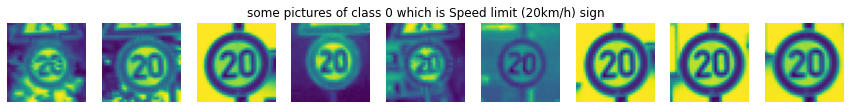

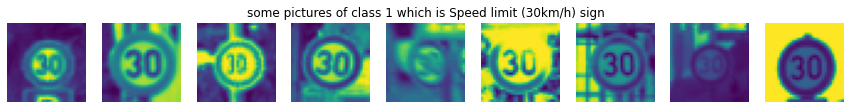

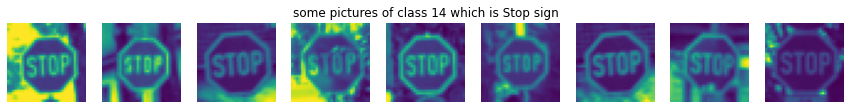

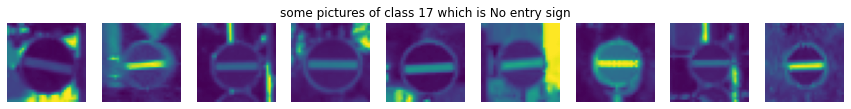

In [121]:
###RGB
get_rgb_pic(0,train_x_rgb)
get_rgb_pic(1,train_x_rgb)
get_rgb_pic(14,train_x_rgb)
get_rgb_pic(17,train_x_rgb)
###gray
get_gray_pic(0,train_x_gray)
get_gray_pic(1,train_x_gray)
get_gray_pic(14,train_x_gray)
get_gray_pic(17,train_x_gray)

As you can see, some of the pictures are really dark and unclear. We will solve this issue by equalizing the pictures.

______________

## Visualizing some of the data in RGB and gray format with histogram equalization :

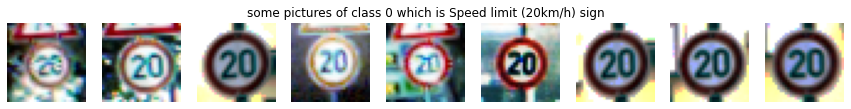

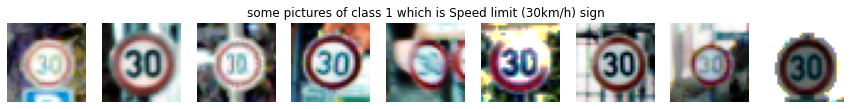

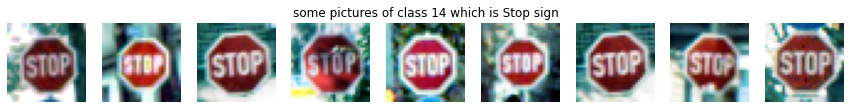

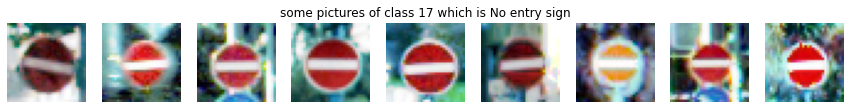

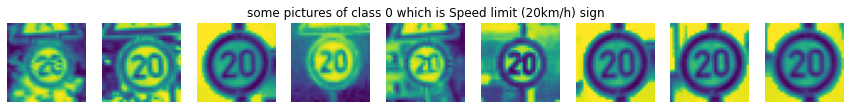

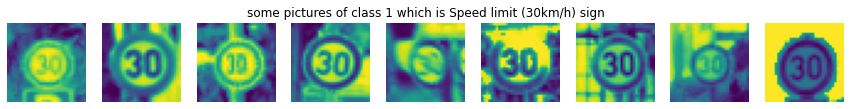

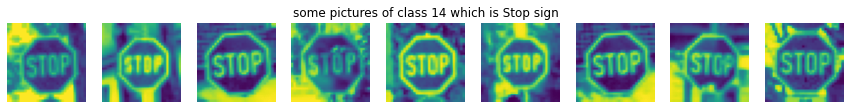

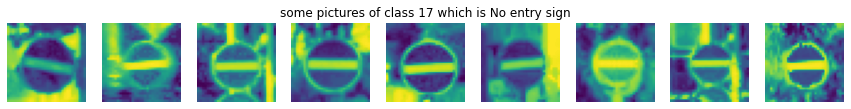

In [122]:
###RGB
get_rgb_pic(0,eq_train_x_rgb)
get_rgb_pic(1,eq_train_x_rgb)
get_rgb_pic(14,eq_train_x_rgb)
get_rgb_pic(17,eq_train_x_rgb)
###gray
get_gray_pic(0,eq_train_x_gray)
get_gray_pic(1,eq_train_x_gray)
get_gray_pic(14,eq_train_x_gray)
get_gray_pic(17,eq_train_x_gray)

Now that we've applied histogram equalizer technique, the pictures are more clear.

__________________

### Checking the distribution of labels :

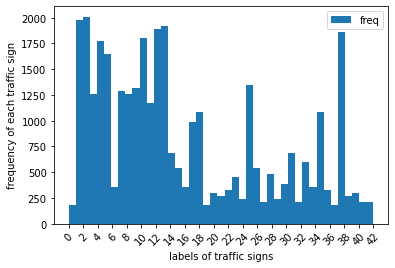

In [123]:
plt.hist(train_dict['labels'],label='freq',bins=43)
plt.legend(loc="upper right")
plt.xticks(range(0,43,2),rotation=45)
plt.xlabel('labels of traffic signs')
plt.ylabel('frequency of each traffic sign')
plt.show()

As you can see, our classes are imbalanced and one solution is to specify weights regarding the above distribution.

#### Dealing with imbalanced classes :

In [124]:
###counting the frequency of each label in the training dataset
x=pd.DataFrame(np.bincount(train_dict['labels']))
x.T

0     1     2     3     4     5    6     7     8     9   ...   33   34  \
0  180  1980  2010  1260  1770  1650  360  1290  1260  1320  ...  599  360   

     35   36   37    38   39   40   41   42  
0  1080  330  180  1860  270  300  210  210  

[1 rows x 43 columns]

In [125]:
### defining a function who will alocate larger weights to smaller classes and vice versa.
def create_class_weight(x):
  class_weights={}
  for i in range(43):
    #calculate a weight regarding the frequency of each label. 
    #the below weight has a reverse relationship with the frequency of the label
    weight=(1/np.squeeze(x.iloc[i])) * (sum(x[0]))/len(x)
    class_weights[i]=weight
  return class_weights



In [126]:
#we will use it later on the .fit function in training
class_weights=create_class_weight(x)

#### Normalizing the image data :

In [127]:
### normalizing the equalized rgb photos
eq_train_x_rgb=eq_train_x_rgb /255.
eq_valid_x_rgb=eq_valid_x_rgb /255.
eq_test_x_rgb=eq_test_x_rgb  /255.
###normalizing the un-equalized rgb photos
train_x_rgb=train_x_rgb/255.
valid_x_rgb=valid_x_rgb/255.
test_x_rgb=test_x_rgb/255.

### normalizing the equalized gray photos
eq_train_x_gray=eq_train_x_gray /255.
eq_valid_x_gray=eq_valid_x_gray /255.
eq_test_x_gray=eq_test_x_gray   /255.

### normalizing the un-equalized gray photos
train_x_gray=train_x_gray/255.
valid_x_gray=valid_x_gray/255.
test_x_gray=test_x_gray/255.

In order to train our network better and avoid overfitting, we tend to use some data augmentation techniques to generate some diverse new images from the pictures we already have.

### Creating image generators for equalized images :

In [128]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t_g = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_g = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15)  

datagen_t_g.fit(eq_train_x_gray)
datagen_v_g.fit(eq_valid_x_gray)
###generating gray images
train_generator_gray_eq=datagen_t_g.flow(eq_train_x_gray,train_y,batch_size=32)
valid_generator_gray_eq=datagen_v_g.flow(eq_valid_x_gray,valid_y,batch_size=32)

##data generator for training data
datagen_t_rgb = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_rgb = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
      width_shift_range=0.1,
      height_shift_range=0.1,
    shear_range=0.15) 

###generating rgb images
datagen_t_rgb.fit(eq_train_x_rgb)
datagen_v_rgb.fit(eq_valid_x_rgb)

train_generator_rgb_eq=datagen_t_rgb.flow(eq_train_x_rgb,train_y,batch_size=32)
valid_generator_rgb_eq=datagen_v_rgb.flow(eq_valid_x_rgb,valid_y,batch_size=32)

### Creating image generators for un-equalized images :

In [129]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t_g = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_g = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15)  

datagen_t_g.fit(train_x_gray)
datagen_v_g.fit(valid_x_gray)
###generating gray images
train_generator_gray_un_eq=datagen_t_g.flow(train_x_gray,train_y,batch_size=32)
valid_generator_gray_un_eq=datagen_v_g.flow(valid_x_gray,valid_y,batch_size=32)

##data generator for training data
datagen_t_rgb = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_rgb = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
      width_shift_range=0.1,
      height_shift_range=0.1,
    shear_range=0.15) 

###generating rgb images
datagen_t_rgb.fit(train_x_rgb)
datagen_v_rgb.fit(valid_x_rgb)

train_generator_rgb_un_eq=datagen_t_rgb.flow(train_x_rgb,train_y,batch_size=32)
valid_generator_rgb_un_eq=datagen_v_rgb.flow(valid_x_rgb,valid_y,batch_size=32)

### Model configuration :

In [130]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout, Dense , Input
from tensorflow.keras import Model
### creating a function for defining layers
def model_config(train_x):
    input_model = Input((train_x.shape[1],train_x.shape[2],train_x.shape[3]),name = 'input_layer')
    
    model =Conv2D(32, (5, 5), padding='same', activation = 'relu',name = 'conv_layer_1')(input_model)
    model =BatchNormalization(name = 'B_N_of_layer_1')(model)
    model =Dropout(0.1,name='D_O_of_layer1')(model)
    model =MaxPooling2D(pool_size=(2, 2),name='M_P_of_layer1')(model)
    
    model =Conv2D(64, (5, 5), padding='valid' , activation = 'relu',name = 'conv_layer_2')(model)
    model =BatchNormalization(name = 'B_N_of_layer_2')(model)
    model =Dropout(0.2,name='D_O_of_layer2')(model)
    model =MaxPooling2D(pool_size=(2, 2),name='M_P_of_layer2')(model)
    
    model =Conv2D(128, (3, 3), padding='valid' , activation = 'relu',name = 'conv_layer_3')(model)
    model =BatchNormalization(name = 'B_N_of_layer_3')(model)
    model =Dropout(0.3,name='D_O_of_layer3')(model)
    model =MaxPooling2D(pool_size=(2, 2),name='M_P_of_layer3')(model)
    model =Flatten(name='flat_layer')(model)
    
    model =Dense(256, activation="relu",name='FC_layer4')(model)
    model =Dropout(0.5,name='D_O_of_layer4')(model)
    output =Dense(43, activation="softmax",name='output_layer')(model)
    model = Model(inputs= [input_model], outputs=[output])
    return model

In [131]:
###summary of a model with gray images
model_config(eq_train_x_gray).summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 32, 32, 32)        832       
_________________________________________________________________
B_N_of_layer_1 (BatchNormali (None, 32, 32, 32)        128       
_________________________________________________________________
D_O_of_layer1 (Dropout)      (None, 32, 32, 32)        0         
_________________________________________________________________
M_P_of_layer1 (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 12, 12, 64)        51264     
_________________________________________________________________
B_N_of_layer_2 (BatchNormali (None, 12, 12, 64)      

In [132]:
###summary of a model with gray images
model_config(eq_train_x_rgb).summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 32, 32, 32)        2432      
_________________________________________________________________
B_N_of_layer_1 (BatchNormali (None, 32, 32, 32)        128       
_________________________________________________________________
D_O_of_layer1 (Dropout)      (None, 32, 32, 32)        0         
_________________________________________________________________
M_P_of_layer1 (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 12, 12, 64)        51264     
_________________________________________________________________
B_N_of_layer_2 (BatchNormali (None, 12, 12, 64)      

As you can see the only difference between the rbg and gray model is that the rgb one in the first convolution layer has three times more parameters than the gray one, regardless of the 32 bias parameters.

##### Defining a function for plotting the accuracy and loss of training set vs validation set :

In [133]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets vs Epochs')
    axs[1].plot(df['val_accuracy'])
    axs[1].plot(df['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets vs Epochs')
    plt.show()

##### Defining functions for compiling and fitting models :

In [134]:
from tensorflow.keras.callbacks import ModelCheckpoint

step=len(train_y)//32
step_v=len(valid_y)//32


### creating a function for compiling the model's settings

def comp(model,lr,opt):
    if opt=='sgd':
        optimum=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    if opt=='adam':
        optimum=tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optimum,loss='categorical_crossentropy', metrics=['accuracy'])
    
### creating a function for fitting the cnn model to data

def fit_model(model,train_generator,valid_generator , weight_bool ,name ):
    
    cp = ModelCheckpoint(filepath=f"{name}_weights.hdf5", monitor = 'val_accuracy',save_best_only=True)
    
    if weight_bool:
        history =  model.fit_generator(train_generator, epochs=35, validation_data=valid_generator,
                        steps_per_epoch= step , validation_steps=step_v , callbacks=[cp],class_weight=class_weights )
    else:
        history =  model.fit_generator(train_generator, epochs=35, validation_data=valid_generator,
                        steps_per_epoch= step , validation_steps=step_v , callbacks=[cp]) 
    return history


# Begin Training :

#### 1) Model without any image equalization on gray pictures :

In [139]:
model_gray_un_eq=model_config(train_x_gray)

comp(model_gray_un_eq,0.0085,'sgd')

history_gray_un_eq=fit_model(model_gray_un_eq,train_generator_gray_un_eq,valid_generator_gray_un_eq,False, 'gray_un_eq')

Epoch 1/35
1087/1087 [==============================] - 9s 8ms/step - loss: 2.5346 - accuracy: 0.2970 - val_loss: 1.4005 - val_accuracy: 0.5739
Epoch 2/35
1087/1087 [==============================] - 9s 8ms/step - loss: 1.0456 - accuracy: 0.6846 - val_loss: 0.7184 - val_accuracy: 0.7920
Epoch 3/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.6390 - accuracy: 0.8078 - val_loss: 0.5931 - val_accuracy: 0.8349
Epoch 4/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.4521 - accuracy: 0.8632 - val_loss: 0.5643 - val_accuracy: 0.8472
Epoch 5/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.3589 - accuracy: 0.8912 - val_loss: 0.3609 - val_accuracy: 0.8889
Epoch 6/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.3000 - accuracy: 0.9097 - val_loss: 0.3421 - val_accuracy: 0.9060
Epoch 7/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.2627 - accuracy: 0.9184 - val_loss: 0.3455 - val_accuracy:

***As you can see, the model that has been trained on unequalized images is suffering from overfitting.***


***Also you'll see that it's accuracy is lower than the equalized version.***


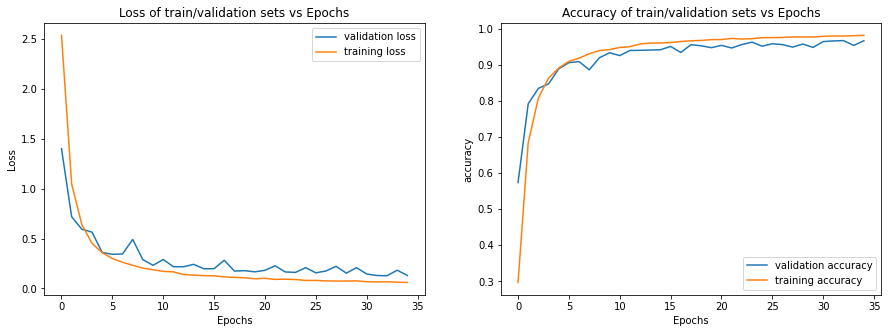

In [140]:
plot_model(history_gray_un_eq)

In [141]:
model_gray_un_eq.evaluate(test_x_gray,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1933 - accuracy: 0.9640


[0.19332937896251678, 0.96397465467453]

#### 2) Model with image equalization on gray pictures :

In [142]:
model_gray_eq=model_config(eq_train_x_gray)

comp(model_gray_eq,0.0085,'sgd')

history_gray_eq=fit_model(model_gray_eq,train_generator_gray_eq,valid_generator_gray_eq,False, 'gray_eq')

Epoch 1/35
1087/1087 [==============================] - 9s 8ms/step - loss: 2.0453 - accuracy: 0.4139 - val_loss: 1.2768 - val_accuracy: 0.5976
Epoch 2/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.8861 - accuracy: 0.7257 - val_loss: 0.5789 - val_accuracy: 0.8168
Epoch 3/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.5516 - accuracy: 0.8284 - val_loss: 0.4127 - val_accuracy: 0.8894
Epoch 4/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.4007 - accuracy: 0.8759 - val_loss: 0.2693 - val_accuracy: 0.9218
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.3160 - accuracy: 0.9006 - val_loss: 0.2525 - val_accuracy: 0.9222
Epoch 6/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.2628 - accuracy: 0.9185 - val_loss: 0.2622 - val_accuracy: 0.9279
Epoch 7/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.2315 - accuracy: 0.9301 - val_loss: 0.2162 - val_accuracy:

In [143]:
'''

'''

'\nmodel_gray.save_weights("gray_version_traffic_signs_weights.h5")\nmodel_gray.save("gray_version_traffic_signs_model.h5")\n'

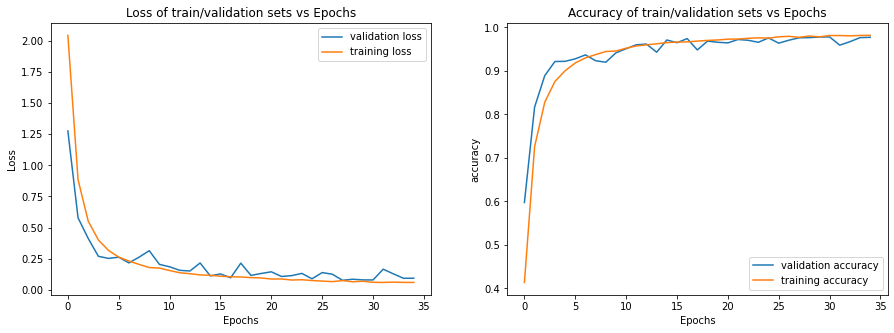

In [144]:
plot_model(history_gray_eq)

In [145]:
model_gray_eq.evaluate(eq_test_x_gray,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1529 - accuracy: 0.9675


[0.1528705507516861, 0.9674584269523621]

***So far we found out the model with equalized images have a better performance.***

***It almost does not over fit and has a better performance on the unseen data. So from now on, we'll use the equalized images as a default setting.***

***Let's see the performance of a weighted model with equalized gray images.***

#### 3) Model with weighted labels on equalized gray images :

In [146]:
model_with_class_weights_gray=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray,0.0085,'sgd')

history_with_class_weights_gray=fit_model(model_with_class_weights_gray,train_generator_gray_eq,valid_generator_gray_eq,True,'gray_with_class_weights')


Epoch 1/35
1087/1087 [==============================] - 9s 8ms/step - loss: 2.9787 - accuracy: 0.1758 - val_loss: 2.9419 - val_accuracy: 0.2924
Epoch 2/35
1087/1087 [==============================] - 9s 8ms/step - loss: 1.7216 - accuracy: 0.4550 - val_loss: 1.2789 - val_accuracy: 0.6193
Epoch 3/35
1087/1087 [==============================] - 9s 8ms/step - loss: 1.0152 - accuracy: 0.6530 - val_loss: 0.6250 - val_accuracy: 0.8013
Epoch 4/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.7015 - accuracy: 0.7572 - val_loss: 0.6394 - val_accuracy: 0.8369
Epoch 5/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.5179 - accuracy: 0.8146 - val_loss: 0.7740 - val_accuracy: 0.8116
Epoch 6/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.4406 - accuracy: 0.8430 - val_loss: 0.4144 - val_accuracy: 0.8807
Epoch 7/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.3624 - accuracy: 0.8655 - val_loss: 0.4416 - val_accuracy:

In [147]:
'''
model_with_class_weights.save_weights("gray_class_weights_traffic_signs_weights.h5")
model_with_class_weights.save("gray_class_weights_traffic_signs_model.h5")
'''

'\nmodel_with_class_weights.save_weights("gray_class_weights_traffic_signs_weights.h5")\nmodel_with_class_weights.save("gray_class_weights_traffic_signs_model.h5")\n'

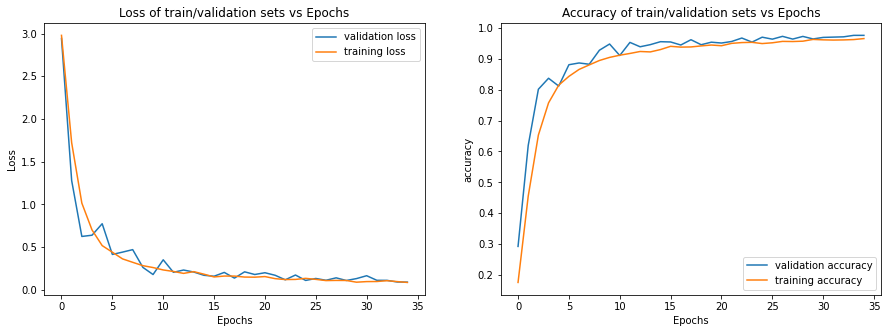

In [148]:
plot_model(history_with_class_weights_gray)

In [149]:
model_with_class_weights_gray.evaluate(eq_test_x_gray,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.9677


[0.16447977721691132, 0.967695951461792]

***As you can see, the performance got slighty better and the overfit problem almost vanished!***

#### 4) Model with image equalization on rgb pictures :

In [150]:
model_rgb_eq=model_config(eq_train_x_rgb)

comp(model_rgb_eq,0.0085,'sgd')

history_rgb_eq=fit_model(model_rgb_eq,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

Epoch 1/35
1087/1087 [==============================] - 16s 14ms/step - loss: 1.9681 - accuracy: 0.4293 - val_loss: 1.0967 - val_accuracy: 0.6606
Epoch 2/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.8149 - accuracy: 0.7432 - val_loss: 0.6751 - val_accuracy: 0.7911
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.5046 - accuracy: 0.8426 - val_loss: 0.3428 - val_accuracy: 0.8921
Epoch 4/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3422 - accuracy: 0.8918 - val_loss: 0.3493 - val_accuracy: 0.8937
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2690 - accuracy: 0.9160 - val_loss: 0.2336 - val_accuracy: 0.9279
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2353 - accuracy: 0.9265 - val_loss: 0.1870 - val_accuracy: 0.9389
Epoch 7/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.1908 - accuracy: 0.9411 - val_loss: 0.1490 -

In [151]:
'''
model_rgb.save_weights("rgb_traffic_signs_weights.h5")
model_rgb.save("rgb_traffic_signs_model.h5")
'''

'\nmodel_rgb.save_weights("rgb_traffic_signs_weights.h5")\nmodel_rgb.save("rgb_traffic_signs_model.h5")\n'

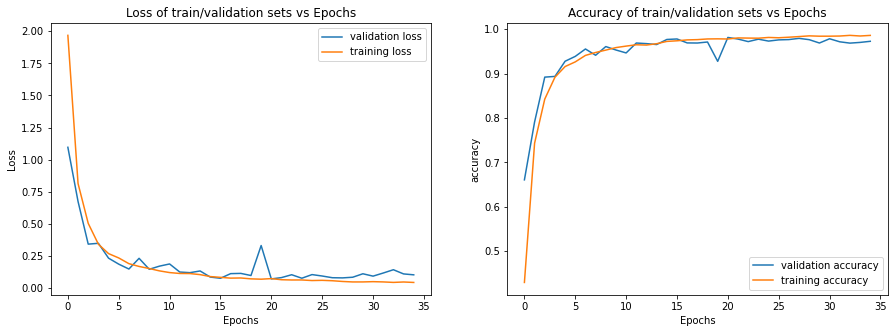

In [152]:
plot_model(history_rgb_eq)

In [153]:
model_rgb_eq.evaluate(eq_test_x_rgb ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1545 - accuracy: 0.9673


[0.15449650585651398, 0.9673000574111938]

***As you can see, model with rgb equalized image will overfit a little bit and it's performance is not better than the gray version.***


***So, we conclude that the best set of inputs is the gray equalized images without any weight classes.***

#### 5) Model with weighted labels on equalized rgb images

For the sake of the discussion we'll try a one last model on equalized rgb images with weighted classes to see what will happen.

In [154]:
model_rgb_eq_weight=model_config(eq_train_x_rgb)

comp(model_rgb_eq_weight,0.0085,'sgd')

history_rgb_eq_weight=fit_model(model_rgb_eq_weight,train_generator_rgb_eq,valid_generator_rgb_eq,True,'rgb')

Epoch 1/35
1087/1087 [==============================] - 15s 14ms/step - loss: 2.7710 - accuracy: 0.2232 - val_loss: 1.9683 - val_accuracy: 0.4056
Epoch 2/35
1087/1087 [==============================] - 15s 14ms/step - loss: 1.5990 - accuracy: 0.4717 - val_loss: 1.7511 - val_accuracy: 0.5342
Epoch 3/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.9660 - accuracy: 0.6531 - val_loss: 1.1940 - val_accuracy: 0.6875
Epoch 4/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.6844 - accuracy: 0.7469 - val_loss: 0.8229 - val_accuracy: 0.7598
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.5198 - accuracy: 0.8052 - val_loss: 0.6169 - val_accuracy: 0.8230
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.4183 - accuracy: 0.8403 - val_loss: 0.3479 - val_accuracy: 0.8848
Epoch 7/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.3424 - accuracy: 0.8679 - val_loss: 0.4398 -

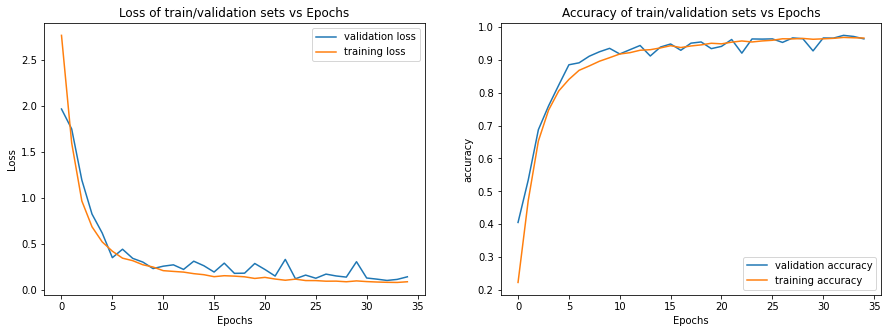

In [155]:
plot_model(history_rgb_eq_weight)

In [156]:
model_rgb_eq_weight.evaluate(eq_test_x_rgb ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1555 - accuracy: 0.9601


[0.15553203225135803, 0.9600949883460999]

As you can see, it has the poorest performance on the unseen data among the previous models.

_______________________________

# Tunnig the selected model which is Model with weighted labels on equalized gray images :

##### 1) adam with learning rate 0.001

In [157]:
model_with_class_weights_gray_test1=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test1,0.001,'adam')

history_model_with_class_weights_gray_test1=fit_model(model_with_class_weights_gray_test1,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test1')

Epoch 1/35
1087/1087 [==============================] - 9s 9ms/step - loss: 2.5079 - accuracy: 0.2881 - val_loss: 1.3784 - val_accuracy: 0.5545
Epoch 2/35
1087/1087 [==============================] - 9s 9ms/step - loss: 1.1061 - accuracy: 0.6188 - val_loss: 0.6316 - val_accuracy: 0.7765
Epoch 3/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.6870 - accuracy: 0.7549 - val_loss: 0.4417 - val_accuracy: 0.8531
Epoch 4/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.4766 - accuracy: 0.8242 - val_loss: 0.3984 - val_accuracy: 0.8891
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.3973 - accuracy: 0.8549 - val_loss: 0.4246 - val_accuracy: 0.8771
Epoch 6/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.3448 - accuracy: 0.8755 - val_loss: 1.0281 - val_accuracy: 0.8250
Epoch 7/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.2878 - accuracy: 0.8941 - val_loss: 0.2114 - val_accuracy:

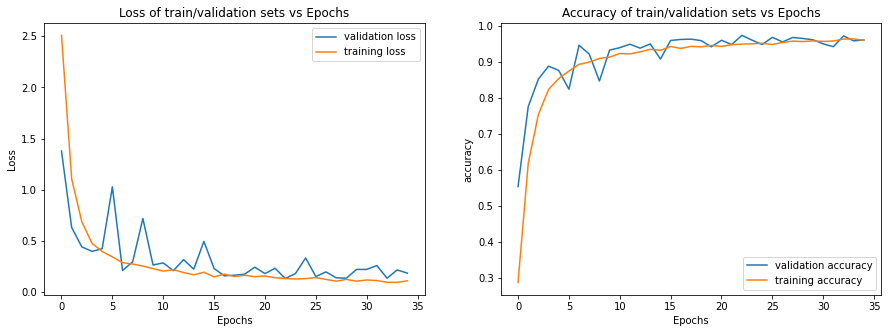

In [158]:
plot_model(history_model_with_class_weights_gray_test1)

In [159]:
model_with_class_weights_gray_test1.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.2789 - accuracy: 0.9471


[0.2788935601711273, 0.9471100568771362]

***Apparently learning rate of 0.001 is worth than 0.0085***

##### 2) adam with learning rate 0.0025

In [160]:
model_with_class_weights_gray_test2=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test2,0.0025,'adam')

history_model_with_class_weights_gray_test2=fit_model(model_with_class_weights_gray_test2,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test2')

Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 2.8580 - accuracy: 0.1977 - val_loss: 2.1734 - val_accuracy: 0.3686
Epoch 2/35
1087/1087 [==============================] - 9s 9ms/step - loss: 1.6396 - accuracy: 0.4643 - val_loss: 1.4867 - val_accuracy: 0.6106
Epoch 3/35
1087/1087 [==============================] - 9s 9ms/step - loss: 1.0902 - accuracy: 0.6279 - val_loss: 0.8408 - val_accuracy: 0.7753
Epoch 4/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.7991 - accuracy: 0.7213 - val_loss: 1.2641 - val_accuracy: 0.7628
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.6274 - accuracy: 0.7765 - val_loss: 0.5266 - val_accuracy: 0.8636
Epoch 6/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.5247 - accuracy: 0.8157 - val_loss: 0.5267 - val_accuracy: 0.8814
Epoch 7/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.4309 - accuracy: 0.8457 - val_loss: 0.4548 - val_accuracy

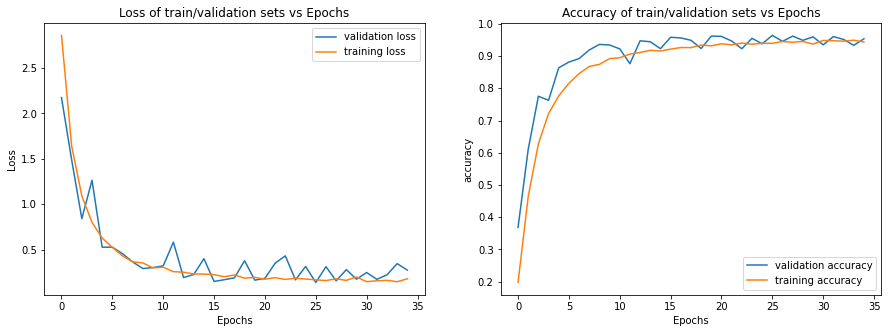

In [161]:
plot_model(history_model_with_class_weights_gray_test2)

In [162]:
model_with_class_weights_gray_test2.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.2663 - accuracy: 0.9529


[0.26626887917518616, 0.9528899192810059]

***The above model is worse than the base model***

##### 3) adam with learning rate 0.005

In [163]:
model_with_class_weights_gray_test3=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test3,0.005,'adam')

history_model_with_class_weights_gray_test3=fit_model(model_with_class_weights_gray_test3,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test3')

Epoch 1/35
1087/1087 [==============================] - 9s 8ms/step - loss: 3.6712 - accuracy: 0.0446 - val_loss: 13.3982 - val_accuracy: 0.0319
Epoch 2/35
1087/1087 [==============================] - 9s 8ms/step - loss: 3.3805 - accuracy: 0.0888 - val_loss: 9.0105 - val_accuracy: 0.1261
Epoch 3/35
1087/1087 [==============================] - 9s 8ms/step - loss: 2.9706 - accuracy: 0.1872 - val_loss: 3.2447 - val_accuracy: 0.3205
Epoch 4/35
1087/1087 [==============================] - 9s 8ms/step - loss: 2.3182 - accuracy: 0.3326 - val_loss: 4.7794 - val_accuracy: 0.3390
Epoch 5/35
1087/1087 [==============================] - 9s 8ms/step - loss: 1.8340 - accuracy: 0.4522 - val_loss: 2.5105 - val_accuracy: 0.5230
Epoch 6/35
1087/1087 [==============================] - 9s 8ms/step - loss: 1.4431 - accuracy: 0.5581 - val_loss: 0.9912 - val_accuracy: 0.7245
Epoch 7/35
1087/1087 [==============================] - 9s 8ms/step - loss: 1.1943 - accuracy: 0.6290 - val_loss: 1.3052 - val_accuracy

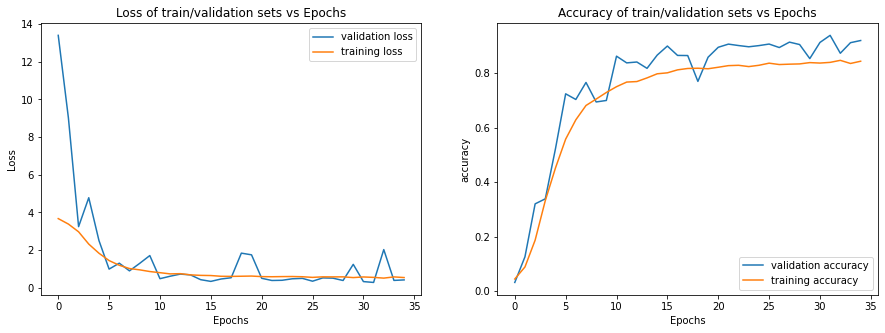

In [164]:
plot_model(history_model_with_class_weights_gray_test3)

In [165]:
model_with_class_weights_gray_test3.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.4175 - accuracy: 0.9126


[0.4174843430519104, 0.9125890731811523]

***After trainig 3 models by adam optimizer with different learning rates, we found out that the best performance we can get by an adam optimizer is with learning rate 0.0025. However, it is still lower than the performance we got by sgd optimizer and learing rate 0.0085***

***So far, adam optimizer didn't show any better performance compare to the sgd optimizer of the base mode. So, we'll swich to sgd and will try to tune it's learning rate.***

##### 4) sgd with learning rate 0.001

In [169]:
model_with_class_weights_gray_test4=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test4,0.001,'sgd')

history_model_with_class_weights_gray_test4=fit_model(model_with_class_weights_gray_test4,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test4')

Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 3.0731 - accuracy: 0.1712 - val_loss: 2.1165 - val_accuracy: 0.4252
Epoch 2/35
1087/1087 [==============================] - 10s 9ms/step - loss: 1.7884 - accuracy: 0.4257 - val_loss: 1.6650 - val_accuracy: 0.4893
Epoch 3/35
1087/1087 [==============================] - 9s 9ms/step - loss: 1.2335 - accuracy: 0.5778 - val_loss: 1.3904 - val_accuracy: 0.5730
Epoch 4/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.8723 - accuracy: 0.6826 - val_loss: 0.7709 - val_accuracy: 0.7457
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.6711 - accuracy: 0.7526 - val_loss: 0.5659 - val_accuracy: 0.8155
Epoch 6/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.5250 - accuracy: 0.8036 - val_loss: 0.3487 - val_accuracy: 0.8887
Epoch 7/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.4353 - accuracy: 0.8376 - val_loss: 0.3333 - val_accur

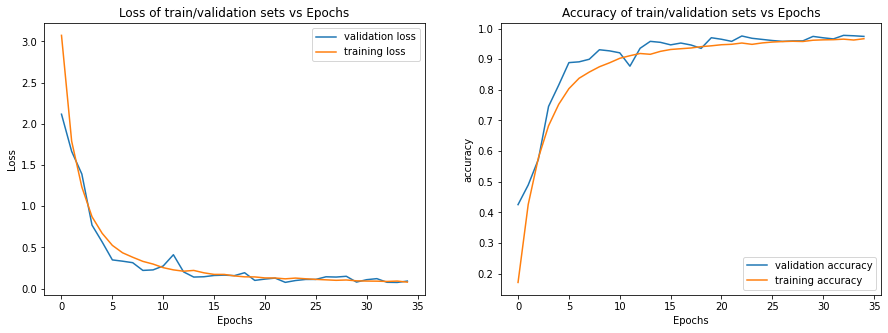

In [170]:
plot_model(history_model_with_class_weights_gray_test4)

In [171]:
model_with_class_weights_gray_test4.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1441 - accuracy: 0.9587


[0.14413097500801086, 0.9586698412895203]

##### 5) sgd with learning rate 0.005

In [172]:
model_with_class_weights_gray_test5=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test5,0.005,'sgd')

history_model_with_class_weights_gray_test5=fit_model(model_with_class_weights_gray_test5,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test5')

Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 2.9660 - accuracy: 0.1766 - val_loss: 2.2523 - val_accuracy: 0.3148
Epoch 2/35
1087/1087 [==============================] - 9s 9ms/step - loss: 1.7859 - accuracy: 0.4355 - val_loss: 1.7945 - val_accuracy: 0.4982
Epoch 3/35
1087/1087 [==============================] - 9s 9ms/step - loss: 1.1577 - accuracy: 0.5982 - val_loss: 1.3102 - val_accuracy: 0.6517
Epoch 4/35
1087/1087 [==============================] - 11s 10ms/step - loss: 0.8272 - accuracy: 0.7038 - val_loss: 0.9903 - val_accuracy: 0.7245
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.6398 - accuracy: 0.7647 - val_loss: 0.5469 - val_accuracy: 0.8399
Epoch 6/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.4998 - accuracy: 0.8121 - val_loss: 0.3698 - val_accuracy: 0.8912
Epoch 7/35
1087/1087 [==============================] - 9s 8ms/step - loss: 0.4205 - accuracy: 0.8398 - val_loss: 0.3567 - val_accur

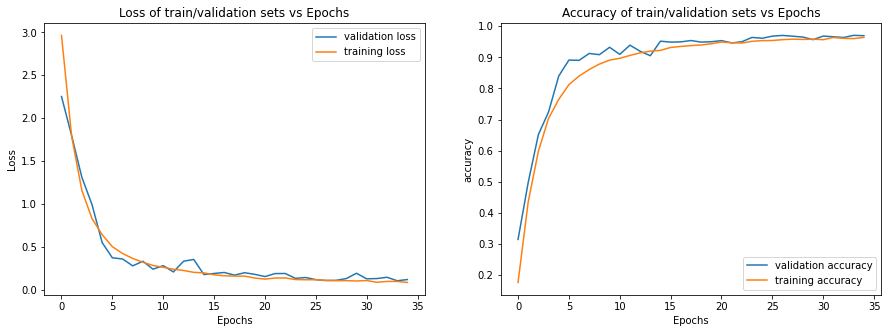

In [173]:
plot_model(history_model_with_class_weights_gray_test5)

In [174]:
model_with_class_weights_gray_test5.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.2168 - accuracy: 0.9599


[0.21680648624897003, 0.9599366784095764]

##### 6) sgd with learning rate 0.0065

In [184]:
model_with_class_weights_gray_test6=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test6,0.0065,'sgd')

history_model_with_class_weights_gray_test6=fit_model(model_with_class_weights_gray_test6,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test6')

Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 2.8689 - accuracy: 0.2021 - val_loss: 2.6591 - val_accuracy: 0.3130
Epoch 2/35
1087/1087 [==============================] - 10s 9ms/step - loss: 1.6630 - accuracy: 0.4716 - val_loss: 1.2218 - val_accuracy: 0.5896
Epoch 3/35
1087/1087 [==============================] - 11s 10ms/step - loss: 1.0606 - accuracy: 0.6380 - val_loss: 1.4169 - val_accuracy: 0.6088
Epoch 4/35
1087/1087 [==============================] - 10s 10ms/step - loss: 0.7188 - accuracy: 0.7426 - val_loss: 0.5569 - val_accuracy: 0.8164
Epoch 5/35
1087/1087 [==============================] - 11s 10ms/step - loss: 0.5578 - accuracy: 0.7931 - val_loss: 0.6000 - val_accuracy: 0.8317
Epoch 6/35
1087/1087 [==============================] - 10s 10ms/step - loss: 0.4529 - accuracy: 0.8323 - val_loss: 0.4216 - val_accuracy: 0.8725
Epoch 7/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.3965 - accuracy: 0.8528 - val_loss: 0.3407 - va

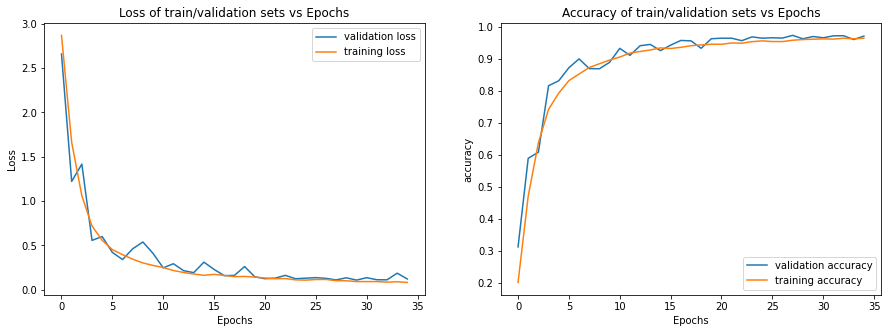

In [185]:
plot_model(history_model_with_class_weights_gray_test6)

In [186]:
model_with_class_weights_gray_test6.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1739 - accuracy: 0.9614


[0.1738589107990265, 0.961361825466156]

##### 7) sgd with learning rate 0.007

In [190]:
model_with_class_weights_gray_test7=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test7,0.007,'sgd')

history_model_with_class_weights_gray_test7=fit_model(model_with_class_weights_gray_test7,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test7')

Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 2.8301 - accuracy: 0.2061 - val_loss: 2.3793 - val_accuracy: 0.3739
Epoch 2/35
1087/1087 [==============================] - 11s 10ms/step - loss: 1.6005 - accuracy: 0.4847 - val_loss: 1.4279 - val_accuracy: 0.5812
Epoch 3/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.9815 - accuracy: 0.6560 - val_loss: 0.6513 - val_accuracy: 0.8004
Epoch 4/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.7096 - accuracy: 0.7495 - val_loss: 0.5535 - val_accuracy: 0.8287
Epoch 5/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.5388 - accuracy: 0.8046 - val_loss: 0.3249 - val_accuracy: 0.8928
Epoch 6/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.4457 - accuracy: 0.8385 - val_loss: 0.4539 - val_accuracy: 0.8727
Epoch 7/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.3704 - accuracy: 0.8628 - val_loss: 0.2643 - val_a

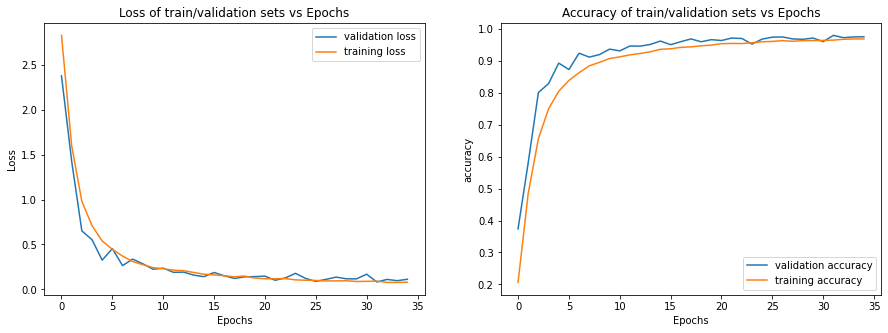

In [191]:
plot_model(history_model_with_class_weights_gray_test7)

In [192]:
model_with_class_weights_gray_test7.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 4ms/step - loss: 0.1872 - accuracy: 0.9619


[0.18718372285366058, 0.9619160890579224]

##### 8) sgd with learning rate 0.008

In [193]:
model_with_class_weights_gray_test8=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray_test8,0.008,'sgd')

history_model_with_class_weights_gray_test8=fit_model(model_with_class_weights_gray_test8,train_generator_gray_eq,valid_generator_gray_eq,True, 'gray_with_class_weights_test8')

Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 3.0267 - accuracy: 0.1683 - val_loss: 2.0241 - val_accuracy: 0.3807
Epoch 2/35
1087/1087 [==============================] - 11s 10ms/step - loss: 1.7022 - accuracy: 0.4683 - val_loss: 2.6977 - val_accuracy: 0.4218
Epoch 3/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.9862 - accuracy: 0.6629 - val_loss: 0.7446 - val_accuracy: 0.7847
Epoch 4/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.6730 - accuracy: 0.7572 - val_loss: 0.5178 - val_accuracy: 0.8495
Epoch 5/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.5175 - accuracy: 0.8187 - val_loss: 0.6560 - val_accuracy: 0.8358
Epoch 6/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.4124 - accuracy: 0.8492 - val_loss: 0.3892 - val_accuracy: 0.8889
Epoch 7/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.3551 - accuracy: 0.8683 - val_loss: 0.4047 - val_a

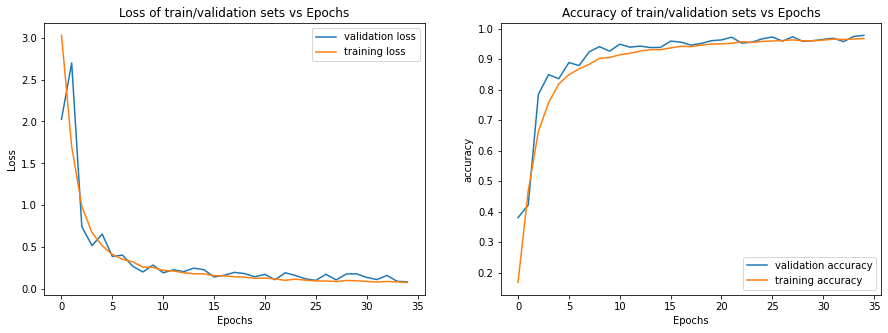

In [194]:
plot_model(history_model_with_class_weights_gray_test8)

In [195]:
model_with_class_weights_gray_test8.evaluate(eq_test_x_gray ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.1598 - accuracy: 0.9690


[0.15977612137794495, 0.9690419435501099]

***So, the best learning rate is 0.008***

***Let's save the best model***

In [226]:
model_with_class_weights_gray_test8.save_weights("best_model_weights.h5")
model_with_class_weights_gray_test8.save("best_model_MODEL.h5")

________________

# Visualizing the output of each conv layer for a specific image :

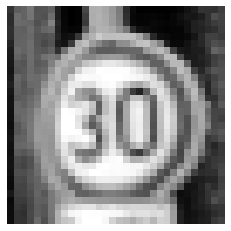

In [227]:
### visualizing the image that we will use later to see each layer's output
plt.imshow(eq_test_x_gray[1],cmap='gray')
plt.axis('off')
plt.show()

In [212]:
### extracting the indexes of conv layers
ln=[]
i=0
for layer in model_with_class_weights_gray_test8.layers:
    i=i+1
    if 'conv' not in layer.name:
        continue
    ln.append((i-1))
    
ln  

[1, 5, 9]

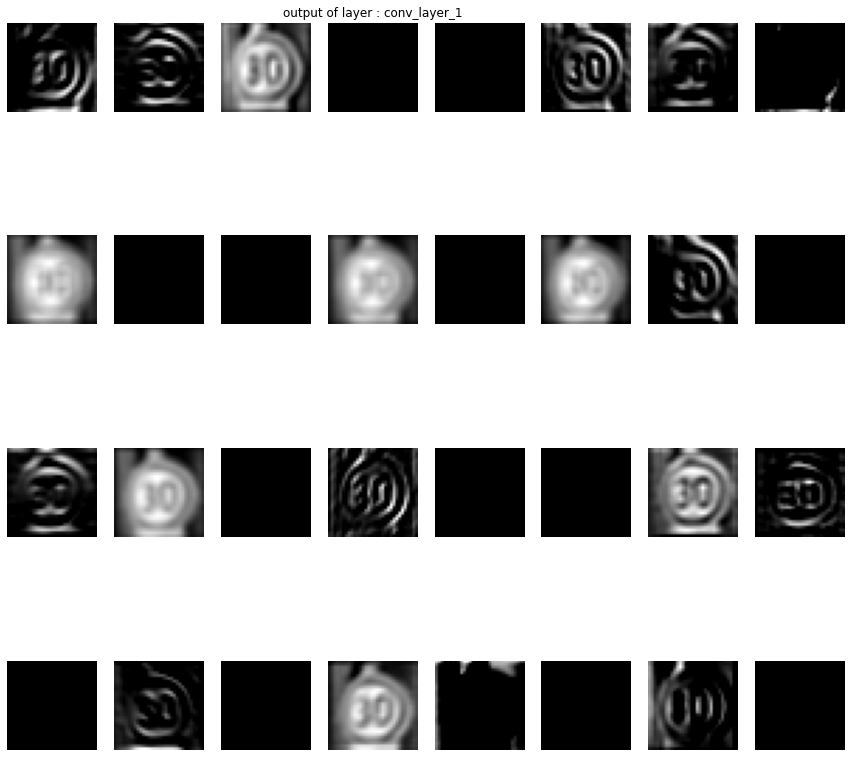

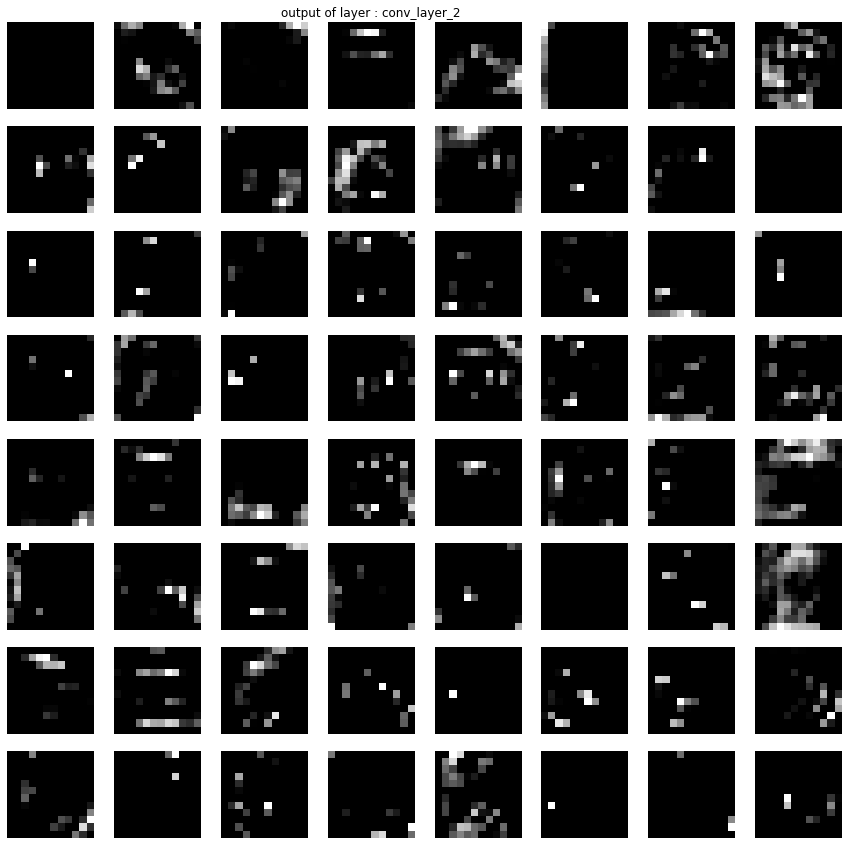

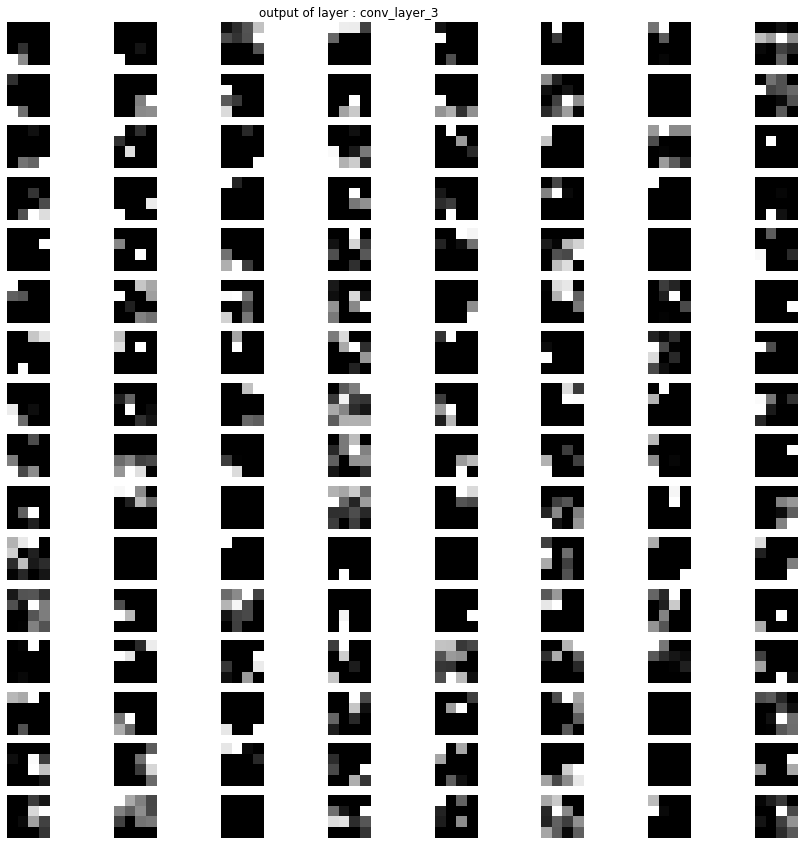

In [298]:
###visualizing conv layers outputs
for n_layer in ln:
    
    model_layer = Model(inputs=model_with_class_weights_gray_test8.inputs, outputs=model_with_class_weights_gray_test8.layers[n_layer].output)
    feature_maps = model_layer.predict(eq_test_x_gray[1].reshape(1,32,32,1))  
    n_col=8
    n_row=feature_maps.shape[-1]//8
    fig, axs = plt.subplots(n_row , n_col,figsize=(15,15))
    i=0
    for j in range(n_row):
        j = tf.convert_to_tensor(j, dtype=tf.int64)
        for z in range(n_col):
            z = tf.convert_to_tensor(z, dtype=tf.int64)
            axs[j,z].imshow(feature_maps[0, :, :, i],cmap='gray')
            i=i+1
            axs[j,z].axis('off')
    axs[0,3].set_title(f"output of layer : {model_with_class_weights_gray_test8.layers[n_layer].name}",loc='center')  
plt.show()

## Investigating some of the signs we mispredict :

In [387]:
pred=model_with_class_weights_gray_test8.predict(eq_test_x_gray)

indx=[]
wrong_pred_label=[]
right_label=[]



for i in range(0,len(test_y)):
    if np.argmax(pred[i])==np.argmax(test_y[i]):
        continue
    wrong_pred_label.append(np.argmax(pred[i]) )  ### an array of mispredict images containing the wrong labels
    right_label.append(np.argmax(test_y[i])) ###an array of mispredict images containing the right labels we failed to predict
    indx.append(i)  ###index of mispredict images in the test set
    
    
indx=np.array(indx)
wrong_pred_label=np.array(wrong_pred_label)
right_label=np.array(right_label)

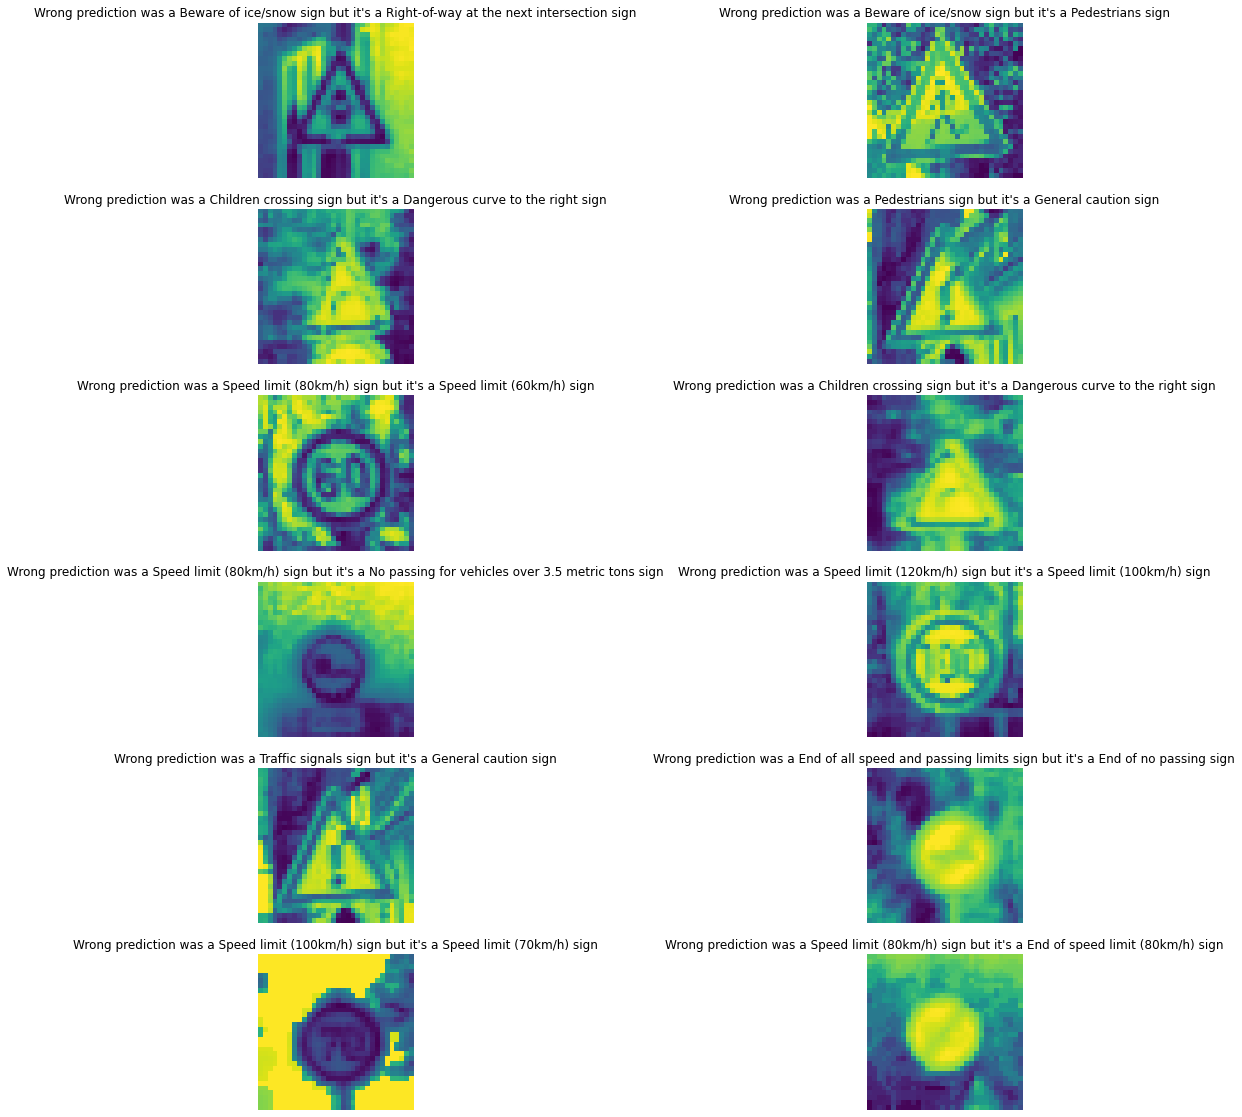

In [396]:
w=30
n_col=2
n_row=6
fig, axs = plt.subplots(n_row ,n_col,figsize=(20,20))
for i in range(n_row):
    for j in range(n_col):
        axs[i,j].imshow(eq_test_x_gray[indx[w],:,:,0])#,cmap='gray'
        axs[i,j].set_title(f"Wrong prediction was a {sign[sign['ClassId']==wrong_pred_label[w]]['SignName'].values[0]} sign but it's a {sign[sign['ClassId']==right_label[w]]['SignName'].values[0]} sign" )
        axs[i,j].axis('off')
        w=w+1
      

plt.show()

## Finding the most frequent mispredictions :

In [405]:
ddf=pd.DataFrame({'wrong_pred_label':wrong_pred_label,'right_label':right_label})
dff=ddf.groupby(['wrong_pred_label','right_label']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
dff

wrong_pred_label  right_label  count
17                 5            3     23
65                26           18     21
7                  2            5     20
78                30           11     19
73                28           20     19
..               ...          ...    ...
50                21           23      1
52                21           31      1
53                22           18      1
56                24           22      1
94                40           30      1

[95 rows x 3 columns]

***As you can see, label 3 was 23 times wrogly predicted as label 5***

***Then it predicted label 18 a lebel 26 for 21 times***

***Also the network wrongly predicted label 5 a label 2 for 20 times***

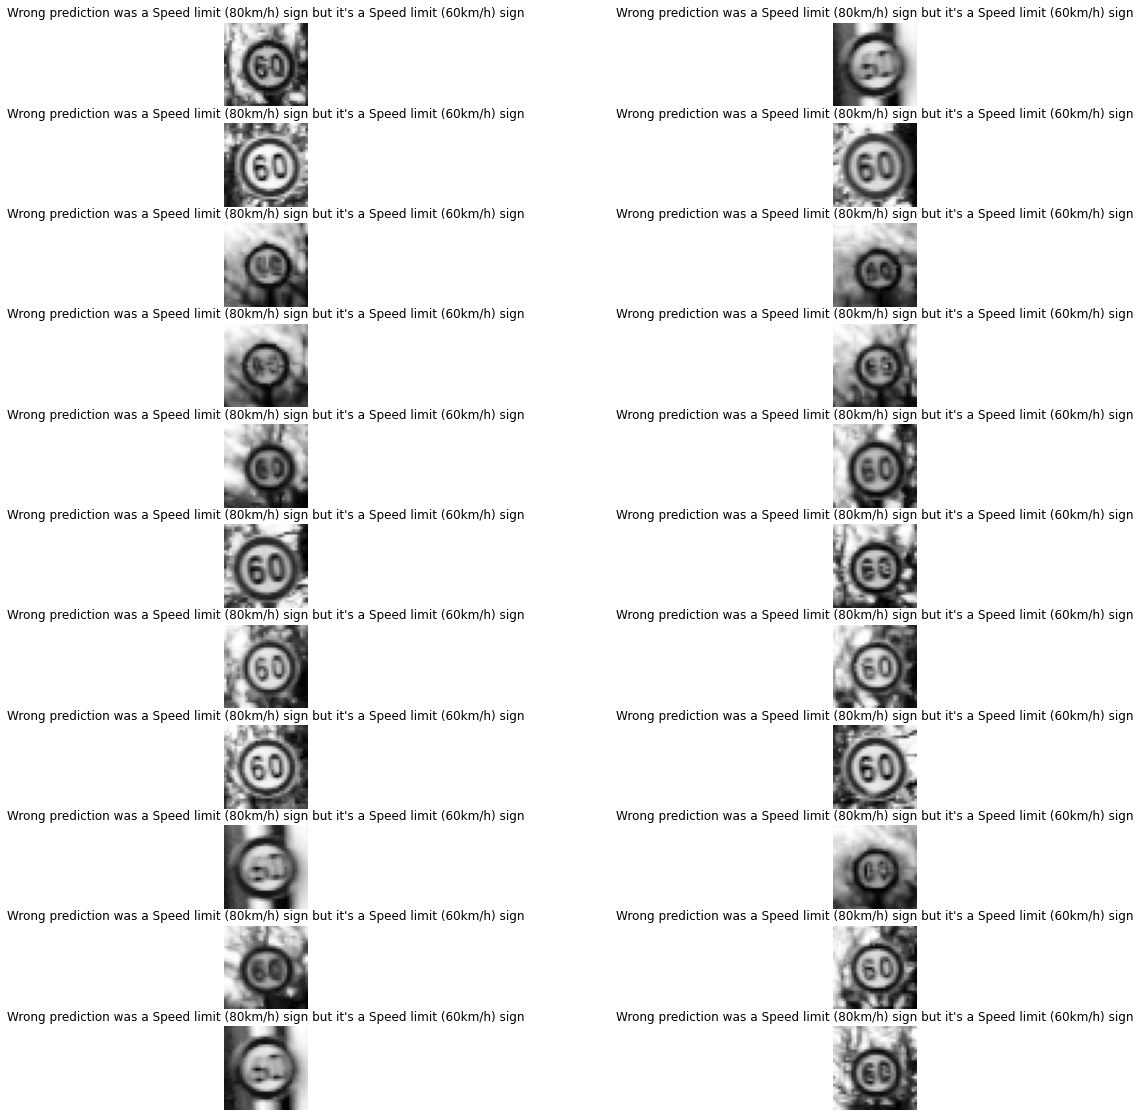

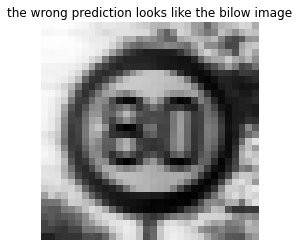

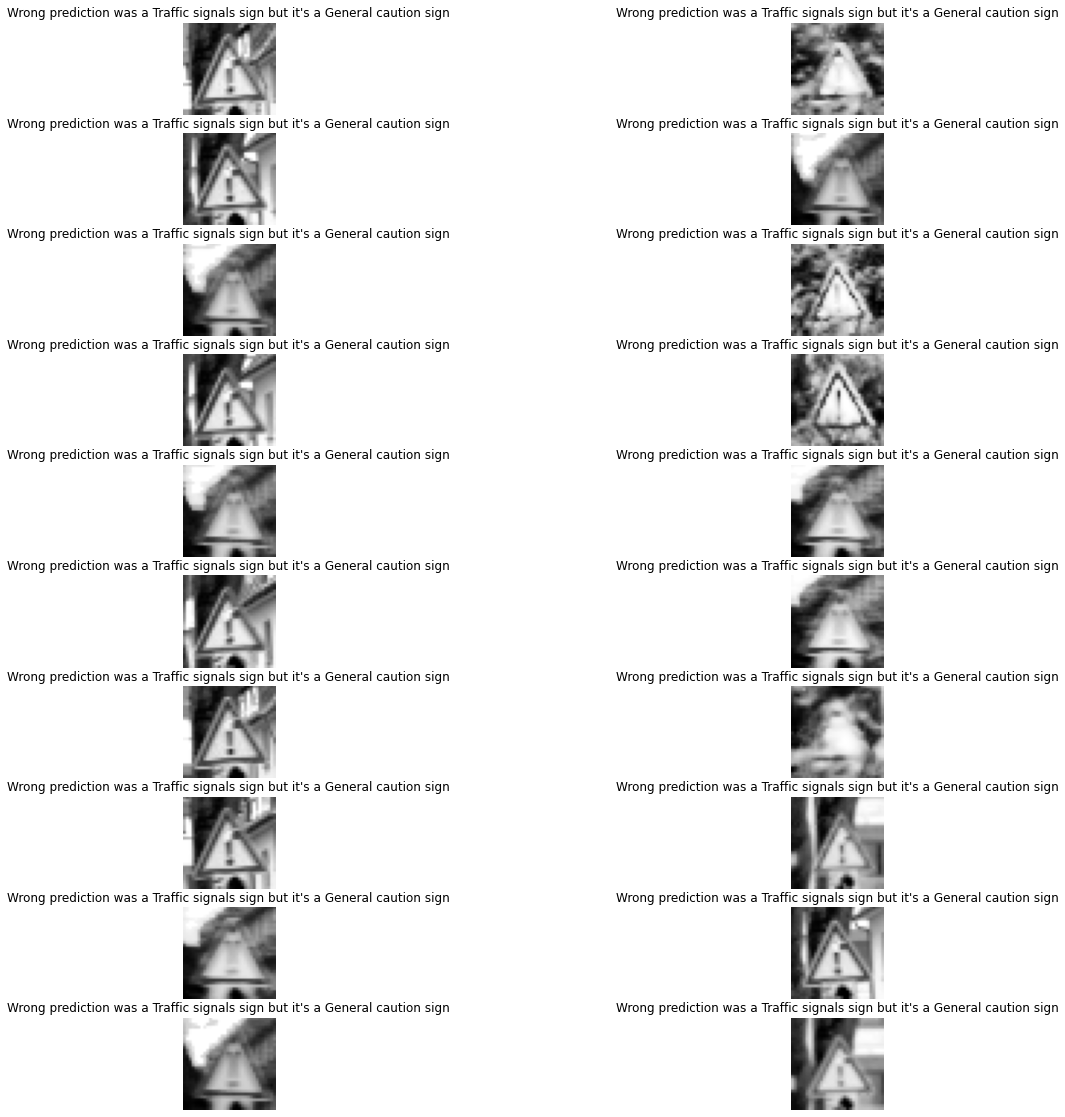

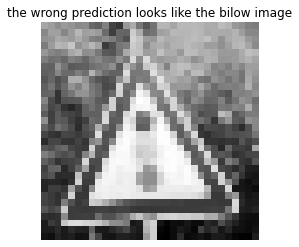

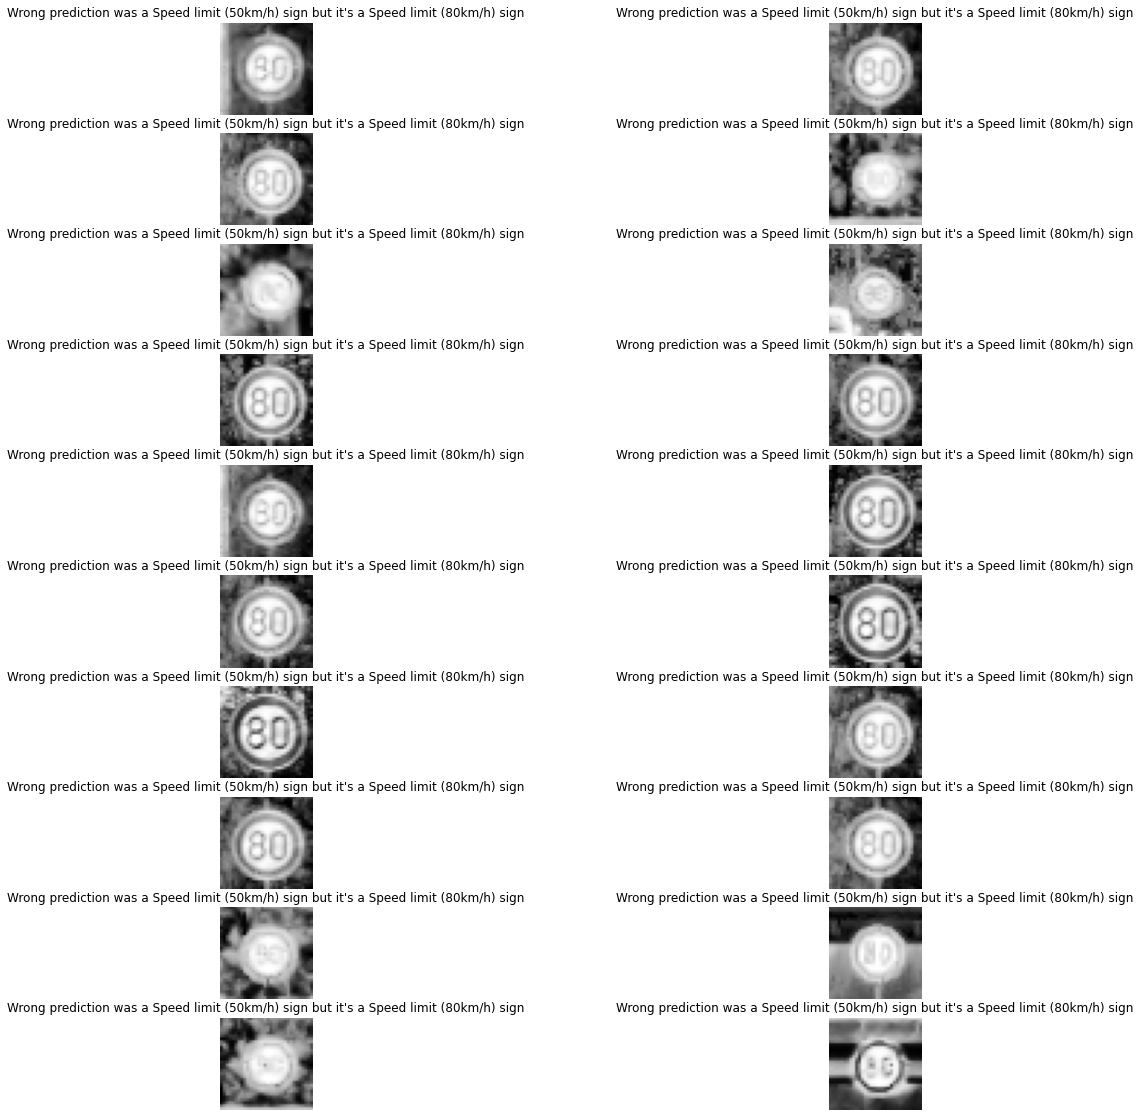

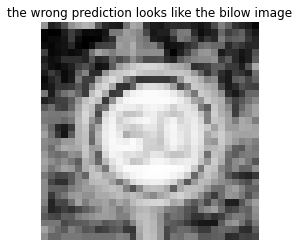

In [485]:
### plotting the three most frequent mistakes

for i in range(3):
    most_frequent_mis_pred=indx[(wrong_pred_label==dff['wrong_pred_label'].iloc[i]) & (right_label==dff['right_label'].iloc[i])]
    n_col=2
    n_row=len(most_frequent_mis_pred)//n_col
    w=0
    fig, axs = plt.subplots(n_row ,n_col ,figsize=(20,20))
    for i in range(n_row):
        for j in range(n_col):
            temp_index=most_frequent_mis_pred[w]
      
            axs[i,j].imshow(eq_test_x_gray[temp_index,:,:,0],cmap='gray')
            axs[i,j].set_title(f"Wrong prediction was a {sign[sign['ClassId']==wrong_pred_label[np.where(indx==temp_index)[0][0]]]['SignName'].values[0]} sign but it's a {sign[sign['ClassId']==right_label[np.where(indx==temp_index)[0][0]]]['SignName'].values[0]} sign" )
            w=w+1
            axs[i,j].axis('off')
    plt.show()
    wrng_pred_indx=np.where(np.argmax(test_y,axis=1)==wrong_pred_label[np.where(indx==temp_index)[0][0]])[0][19]
    plt.imshow(eq_test_x_gray[wrng_pred_indx],cmap='gray')
    plt.title('the wrong prediction looks like the bilow image')
    plt.axis('off')
    plt.show()
    print("\n")
    